[NAVER sentiment movie corpus](https://github.com/e9t/nsmc)

- [1) 데이터 준비와 확인](#1%29-데이터-준비와-확인)
- [2) 데이터로더 구성](#2%29-데이터로더-구성)

# 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
- [x] 데이터의 중복 제거 -> 중복 없음.  
- [x] NaN 결측치 제거  
- [x] 한국어 토크나이저로 토큰화  
- [x] 불용어(Stopwords) 제거  
- [x] 사전 word_to_index 구성  
- [x] 텍스트 스트링을 사전 인덱스 스트링으로 변환  
- [x] X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    # 중복 제거
    # 중복 데이터 없음.
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    # document 열에만 NA있어서 바로 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화, 불용어 처리
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 to 인덱스
    def wordlist_to_idxlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_idxlist, X_train))
    X_test = list(map(wordlist_to_idxlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
- [x] 데이터셋 내 문장 길이 분포
- [x] 적절한 최대 문장 길이 지정
- [x] keras.preprocessing.sequence.pad_sequences 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델 구성 및 validation set 구성
- [x] 3가지 이상 모델

In [7]:
train_len = int(X_train.shape[0] * 0.2)
print(train_len)

# validation set 분리
X_val = X_train[:train_len]
y_val = y_train[:train_len]

# validation set을 제외한 
partial_X_train = X_train[train_len:]  
partial_y_train = y_train[train_len:]

print(partial_X_train.shape)
print(partial_y_train.shape)

29236
(116946, 41)
(116946,)


In [8]:
vocab_size = 10000
word_vector_dim = 100

## LSTM

In [9]:
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


## CNN

In [10]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## CNN globalMaxPooling

In [11]:
maxpooling_model = tf.keras.Sequential()
maxpooling_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
maxpooling_model.add(tf.keras.layers.GlobalMaxPooling1D())
maxpooling_model.add(tf.keras.layers.Dense(8, activation='relu'))
maxpooling_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

maxpooling_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


## Transformer

In [12]:
# 일단 프로젝트부터 제출하고 나중에 작성하자

# 5) 모델 훈련 개시

## LSTM

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# 얼리 스탑핑 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터할 지표 설정 (검증 손실)
                               patience=3,         # 성능이 개선되지 않더라도 기다릴 epoch 수
                               restore_best_weights=True)  # 최적의 가중치로 복원할지 여부

rnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],  # 얼리 스탑핑 콜백 추가
                        verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.4755 - accuracy: 0.7987 - val_loss: 0.3613 - val_accuracy: 0.8473
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3361 - accuracy: 0.8613 - val_loss: 0.3477 - val_accuracy: 0.8492
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3078 - accuracy: 0.8749 - val_loss: 0.3438 - val_accuracy: 0.8531
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2891 - accuracy: 0.8831 - val_loss: 0.3469 - val_accuracy: 0.8515
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2719 - accuracy: 0.8917 - val_loss: 0.3506 - val_accuracy: 0.8538
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2552 - accuracy: 0.8993 - val_loss: 0.3583 - val_accuracy: 0.8502


In [14]:
results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3543 - accuracy: 0.8468
[0.3542940616607666, 0.846796989440918]


## CNN

In [15]:
# 얼리 스탑핑 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터할 지표 설정 (검증 손실)
                               patience=3,         # 성능이 개선되지 않더라도 기다릴 epoch 수
                               restore_best_weights=True)  # 최적의 가중치로 복원할지 여부

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history = cnn_model.fit(partial_X_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],  # 얼리 스탑핑 콜백 추가
                            verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.4464 - accuracy: 0.7870 - val_loss: 0.3421 - val_accuracy: 0.8497
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2992 - accuracy: 0.8751 - val_loss: 0.3266 - val_accuracy: 0.8581
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2333 - accuracy: 0.9080 - val_loss: 0.3451 - val_accuracy: 0.8564
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1593 - accuracy: 0.9425 - val_loss: 0.3958 - val_accuracy: 0.8470
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1002 - accuracy: 0.9666 - val_loss: 0.4735 - val_accuracy: 0.8446


In [16]:
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3378 - accuracy: 0.8553
[0.3378426730632782, 0.8552800416946411]


## CNN globalMaxPooling

In [17]:
# 얼리 스탑핑 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터할 지표 설정 (검증 손실)
                               patience=3,         # 성능이 개선되지 않더라도 기다릴 epoch 수
                               restore_best_weights=True)  # 최적의 가중치로 복원할지 여부

maxpooling_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = maxpooling_model.fit(partial_X_train,
                               partial_y_train,
                               epochs=epochs,
                               batch_size=512,
                               validation_data=(X_val, y_val),
                               callbacks=[early_stopping],  # 얼리 스탑핑 콜백 추가
                               verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 5ms/step - loss: 0.5032 - accuracy: 0.7896 - val_loss: 0.3572 - val_accuracy: 0.8425
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3255 - accuracy: 0.8616 - val_loss: 0.3363 - val_accuracy: 0.8515
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2798 - accuracy: 0.8849 - val_loss: 0.3373 - val_accuracy: 0.8542
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2448 - accuracy: 0.9024 - val_loss: 0.3462 - val_accuracy: 0.8548
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2120 - accuracy: 0.9184 - val_loss: 0.3637 - val_accuracy: 0.8541


In [18]:
results = maxpooling_model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3464 - accuracy: 0.8492
[0.3464232087135315, 0.8492381572723389]


## Transformer

In [19]:
# 일단 프로젝트부터 제출하고 나중에 작성하자

# 6) Loss, Accuracy 그래프 시각화
가장 성능이 좋은 cnn_model에 대해서만 진행.

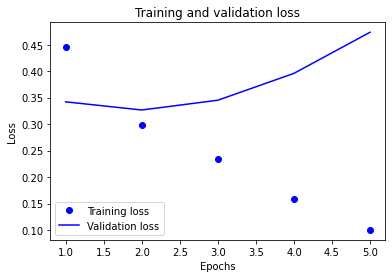

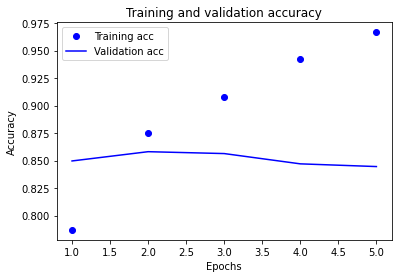

In [20]:
import matplotlib.pyplot as plt

history_dict = cnn_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [21]:
# embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# # tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# # embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
# raw_inputs = np.array(get_encoded_sentences(train_data['document'], word_to_index), dtype=object)
# raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
#                                                        value=word_to_index['<PAD>'],
#                                                        padding='post',
#                                                        maxlen=maxlen)
# output = embedding(raw_inputs)
# print(output.shape)

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- word2vec_ko.model 활용
- load() 형태로 모둘 불러오기. .wv 붙여서 활용.
- [ ] 자체학습한 임베딩과 사전학습 임베딩 비교 분석
- [ ] 네이버 영화리뷰 데이터 감성분석 정확도 

In [22]:
embedding_layer = cnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['영화']
len(vector)

100

In [24]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word_vectors.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [25]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning


cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

TypeError: argument of type 'Word2Vec' is not iterable